#  0.0 Introdução 

## 0.1 Problema  de Negócio

Rossmann opera mais de 3.000 drogarias em 7 países europeus. Atualmente, os gerentes de loja da Rossmann têm a tarefa de prever suas vendas diárias com até seis semanas de antecedência. 

**Motivação:** A previsão de vendas foi requisitada pelo CFO em uma reunião mensal sobre os resultados das lojas. 

**Causa Raiz:** Necessidade de realizar reformas nas lojas, necessitando um aporte de dinheiro para concluir essas reformas. 

Assim, deve ser respondido as seguintes perguntas: 
- Qual sera o valor das vendas diarias para as lojas nas proximas 6 semanas? 

## 0.2 Planejamento da Entrega 

1. Resposta 
> previsão das vendas 

2. Formato de entrega
> Json com a previsão para cada loja 

3. Local de entrega 
> API 

## 0.3 Planejamento do Processo 

- Merger dados de treino e features de lojas pelo id da loja. 
- Tratamento de dados faltantes
- Mapa mental de Hipoteses. 
- Criação de novas Features e filtrar variaveis
- EDA
- Modelar dados(Normalização, rescaling, Encoding)
- Selecao de variaveis por importancia(Random Florest) 
- Modelar algoritmo e crosvalidation
- Fine tuning
- Avaliação do algoritmo e Performance de Negocio
- Criar Classe para preparar o dado e aplicar previsao
- Criar API Handler 
- Realizar Deploy

##  0.4 Planejamento de Entrega 

1. Fontes dos Dados
- **Kaggle** https://www.kaggle.com/c/rossmann-store-sales/data

2. Ferramentas 
- Python 3.8 
- jupyter Notebook 
- Pycharm
- sklearn
- coggle

# 1.0 Imports

In [1]:
# manipulacao de dados
import pandas as pd
import numpy as np

#estatistica
import math

#graficos 
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# manipulacoa de text 
import inflection

#time
import datetime

## 1.1 Funções de Ajuda

In [2]:
sns.set(rc={'figure.figsize':(16,30)})

## 1.2 Carregando Dados

In [3]:
df_sales_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/raw/store.csv', low_memory=False)

In [4]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on = 'Store')

# 2.0 Analise Descritiva 

In [5]:
# check point 
df2 = df_raw.copy()

##  2.1 Renomear Colunas

In [6]:
cols_old = df2.columns
snake_case = lambda x : inflection.underscore(x)
cols_new = list(map(snake_case, cols_old))

# rename cols
df2.columns = cols_new

## 2.2 Dimensão dos Dados

O dataset possui 1017209 linhas e 18 colunas. 

In [7]:
df2.shape

(1017209, 18)

## 2.3 Tipo dos Atributos

In [8]:
# verificando o tipo dos atributos
df2.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
# Alterando o tipo da coluna 'date' de OBJECT para DATETIME
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')

## 2.4 Dados Faltantes(NA)

O dataset possui 6 colunas que contem linhas vazias. (podendo prejudicar a performance dos algoritmos)
- competition_distance
- competition_open_since_month
- competition_open_since_year
- promo2_since_week
- promo2_since_year
- promo_interval

**Por que estao NA? Regra de negocio?**

In [10]:
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 2.5 Preenchendo NA 

In [11]:
df2['competition_distance'].max()

75860.0

In [12]:
# competition_distance
df2['competition_distance'] = df2['competition_distance'].apply(lambda x : 200000.0 if math.isnan(x) 
                                                                else x )

# competition_open_since_month
df2['competition_open_since_month'] = df2.apply(lambda x : x['date'].month 
                                                if math.isnan(x['competition_open_since_month']) 
                                                                else x['competition_open_since_month'], axis=1 )

# competition_open_since_year
df2['competition_open_since_year'] = df2.apply(lambda x : x['date'].year 
                                                if math.isnan(x['competition_open_since_year']) 
                                                                else x['competition_open_since_year'], axis=1 )
# promo2_since_week
df2['promo2_since_week'].fillna(0, inplace=True)

# promo2_since_year
df2['promo2_since_year'].fillna(0, inplace=True)

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct'
             , 11: 'Nov', 12: 'Dec'}

df2['promo_interval'].fillna(0, inplace=True)
df2['month_map'] = df2['date'].dt.month.map(month_map)

df2['is_promo2'] = df2[['promo_interval', 'month_map']].apply(lambda x : 0 if x['promo_interval'] == 0 else
                                                              1 if x['month_map'] in x['promo_interval'].split(',')
                                                              else 0, axis=1)


In [13]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo2                                int64
dtype: object

In [14]:
# alterando o tipo dos catributos 'promo2_since_week', 'promo2_since_year' para int 
df2['promo2_since_week'] = df2['promo2_since_week'].astype(int)
df2['promo2_since_year'] = df2['promo2_since_year'].astype(int)

# alterando o tipo dos catributos 'competition_open_since_month', 'competition_open_since_year' para int 
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype(int)
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype(int)

## 2.6 Estatística Descritiva  

In [15]:
num_attributes = ['store' ,'day_of_week', 'sales', 'customers', 'competition_distance', 
                  'competition_open_since_month', 'competition_open_since_year', 'promo2_since_week',
                 'promo2_since_year']
cat_attributes = ['open', 'promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'promo2',
                 'promo_interval', 'month_map', 'is_promo2']

### 2.6.1 Atributos Numericos 

In [16]:
# calculando a Kurtosis e skew dos atributos numericos 
num_kurtosis = df2[num_attributes].apply(lambda x : x.kurtosis())
num_skew = df2[num_attributes].apply(lambda x : x.skew())
df_kurt_skew = pd.DataFrame([num_kurtosis, num_skew]).T
df_kurt_skew.columns = ['kurtosis', 'skew']

In [17]:
df_describe = df2[num_attributes].describe().T

In [18]:
pd.concat([df_describe, df_kurt_skew], axis = 1)

,count,mean,std,min,25%,50%,75%,max,kurtosis,skew
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0,-1.200524,-0.000955
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0,-1.246873,0.001593
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0,1.778375,0.641460
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0,7.091773,1.598650
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0,147.789712,10.242344
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0,-1.232607,-0.042076
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0,124.071304,-7.235657
promo2_since_week,1017209.0,11.647665,15.323928,0.0,0.0,1.0,22.0,50.0,-0.498322,1.003390
promo2_since_year,1017209.0,1007.010608,1005.876930,0.0,0.0,2009.0,2012.0,2015.0,-1.999993,-0.002251


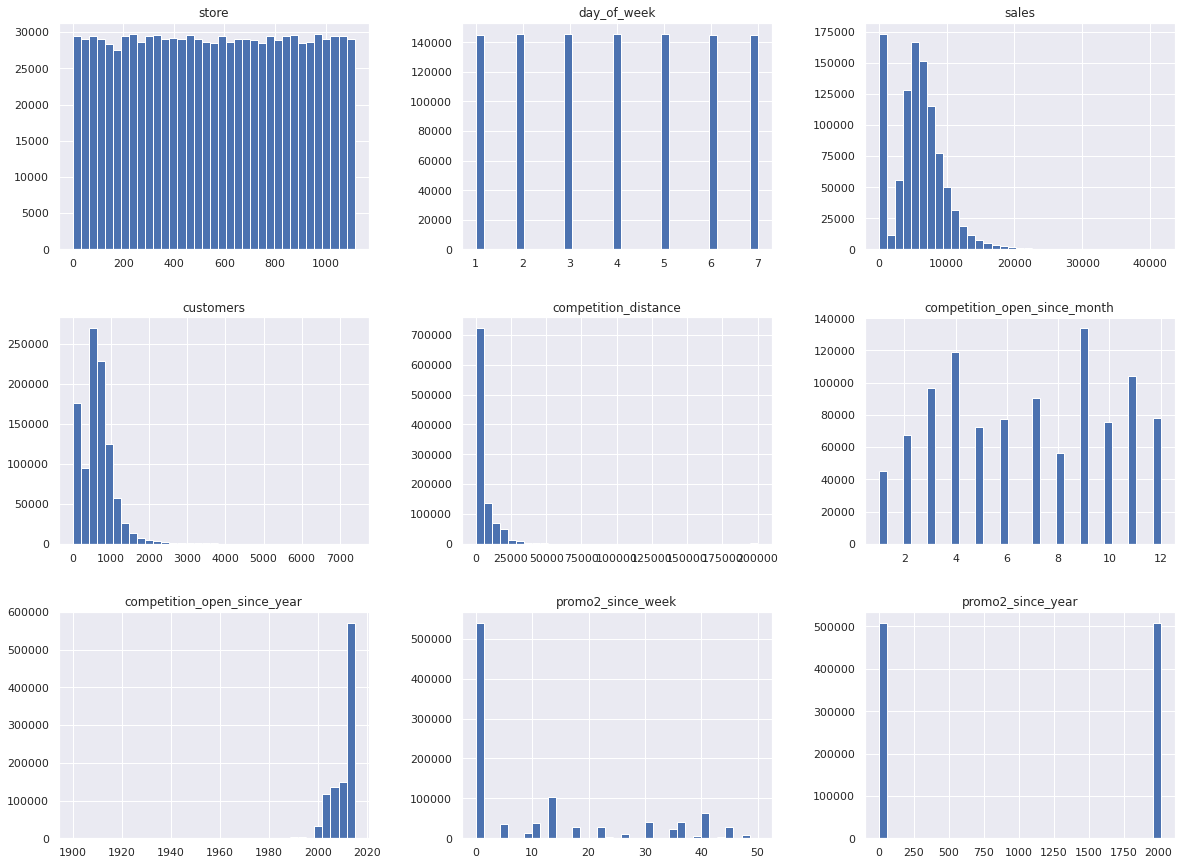

In [19]:
df2[num_attributes].hist(bins = 35, figsize = (20,15));

### 2.6.2 Atributos Categoricos

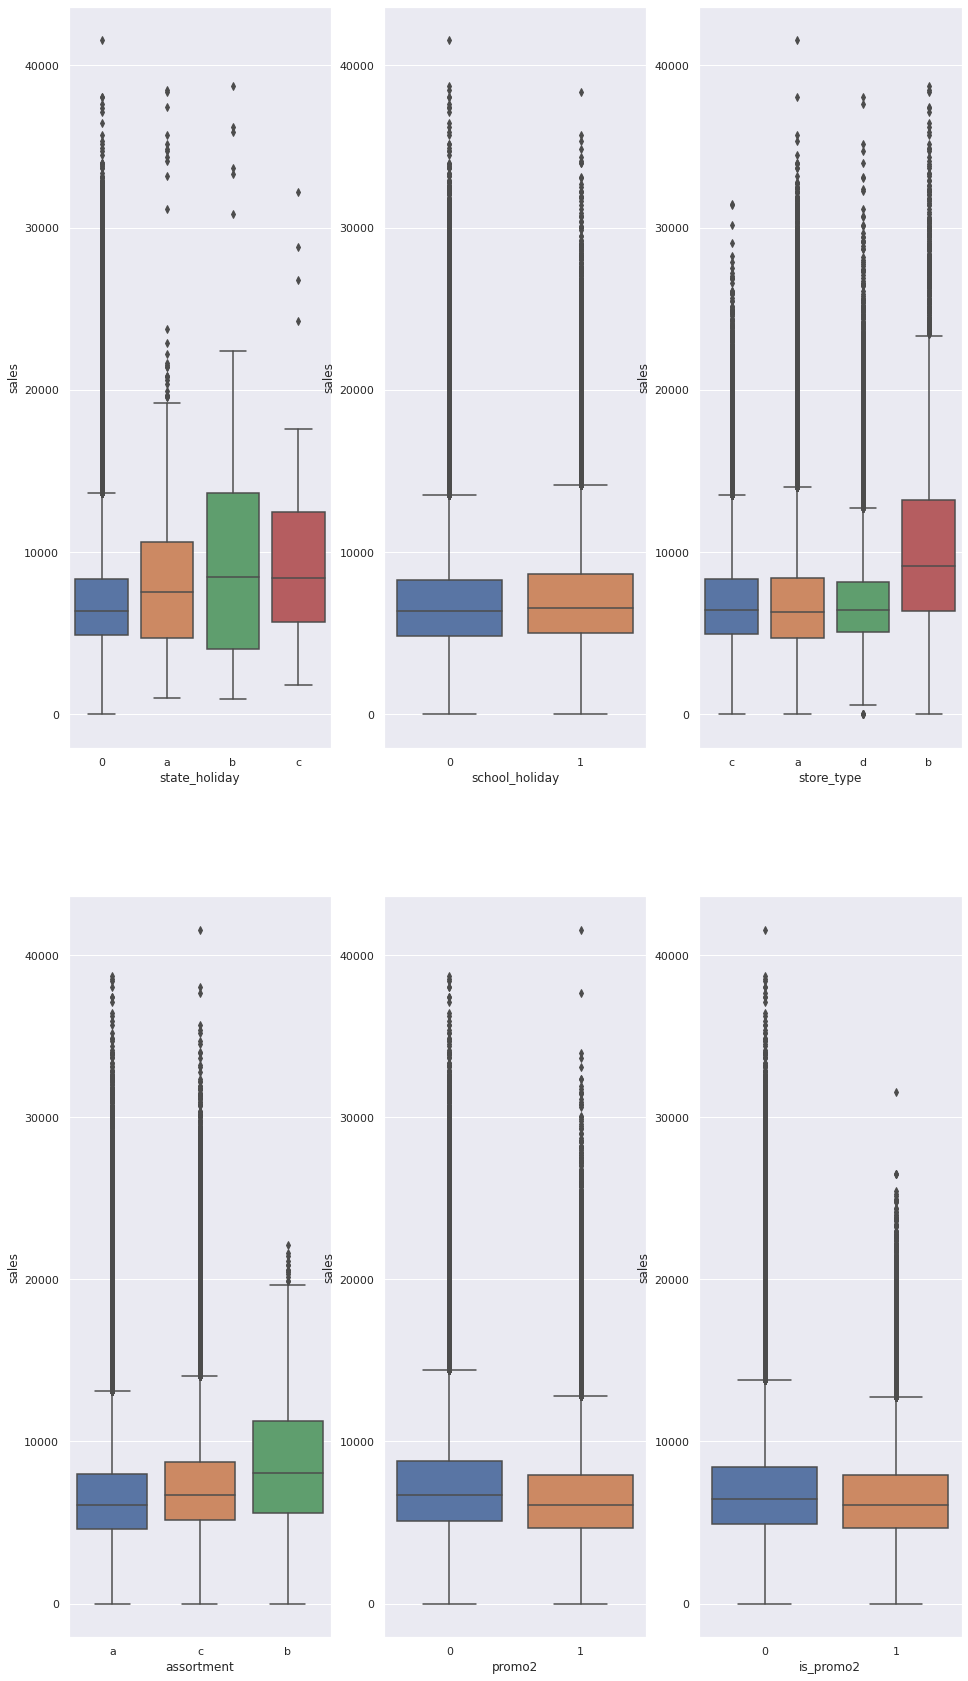

In [20]:
# state_holiday
aux = df2[df2['open']==1]
plt.subplot(2,3,1)
sns.boxplot(x = 'state_holiday', y ='sales', data=aux);

#school_holiday
plt.subplot(2,3,2)
sns.boxplot(x = 'school_holiday', y ='sales', data=aux);

#store_type
plt.subplot(2,3,3)
sns.boxplot(x = 'store_type', y ='sales', data=aux);


#assortment
plt.subplot(2,3,4)
sns.boxplot(x = 'assortment', y ='sales', data=aux);

#assortment
plt.subplot(2,3,5)
sns.boxplot(x = 'promo2', y ='sales', data=aux);


#assortment
plt.subplot(2,3,6)
sns.boxplot(x = 'is_promo2', y ='sales', data=aux);



# 3.0 Feature Engineering  

In [21]:
df3 = df2.copy()

## 3.1 Mapa Mental de Hipoteses 

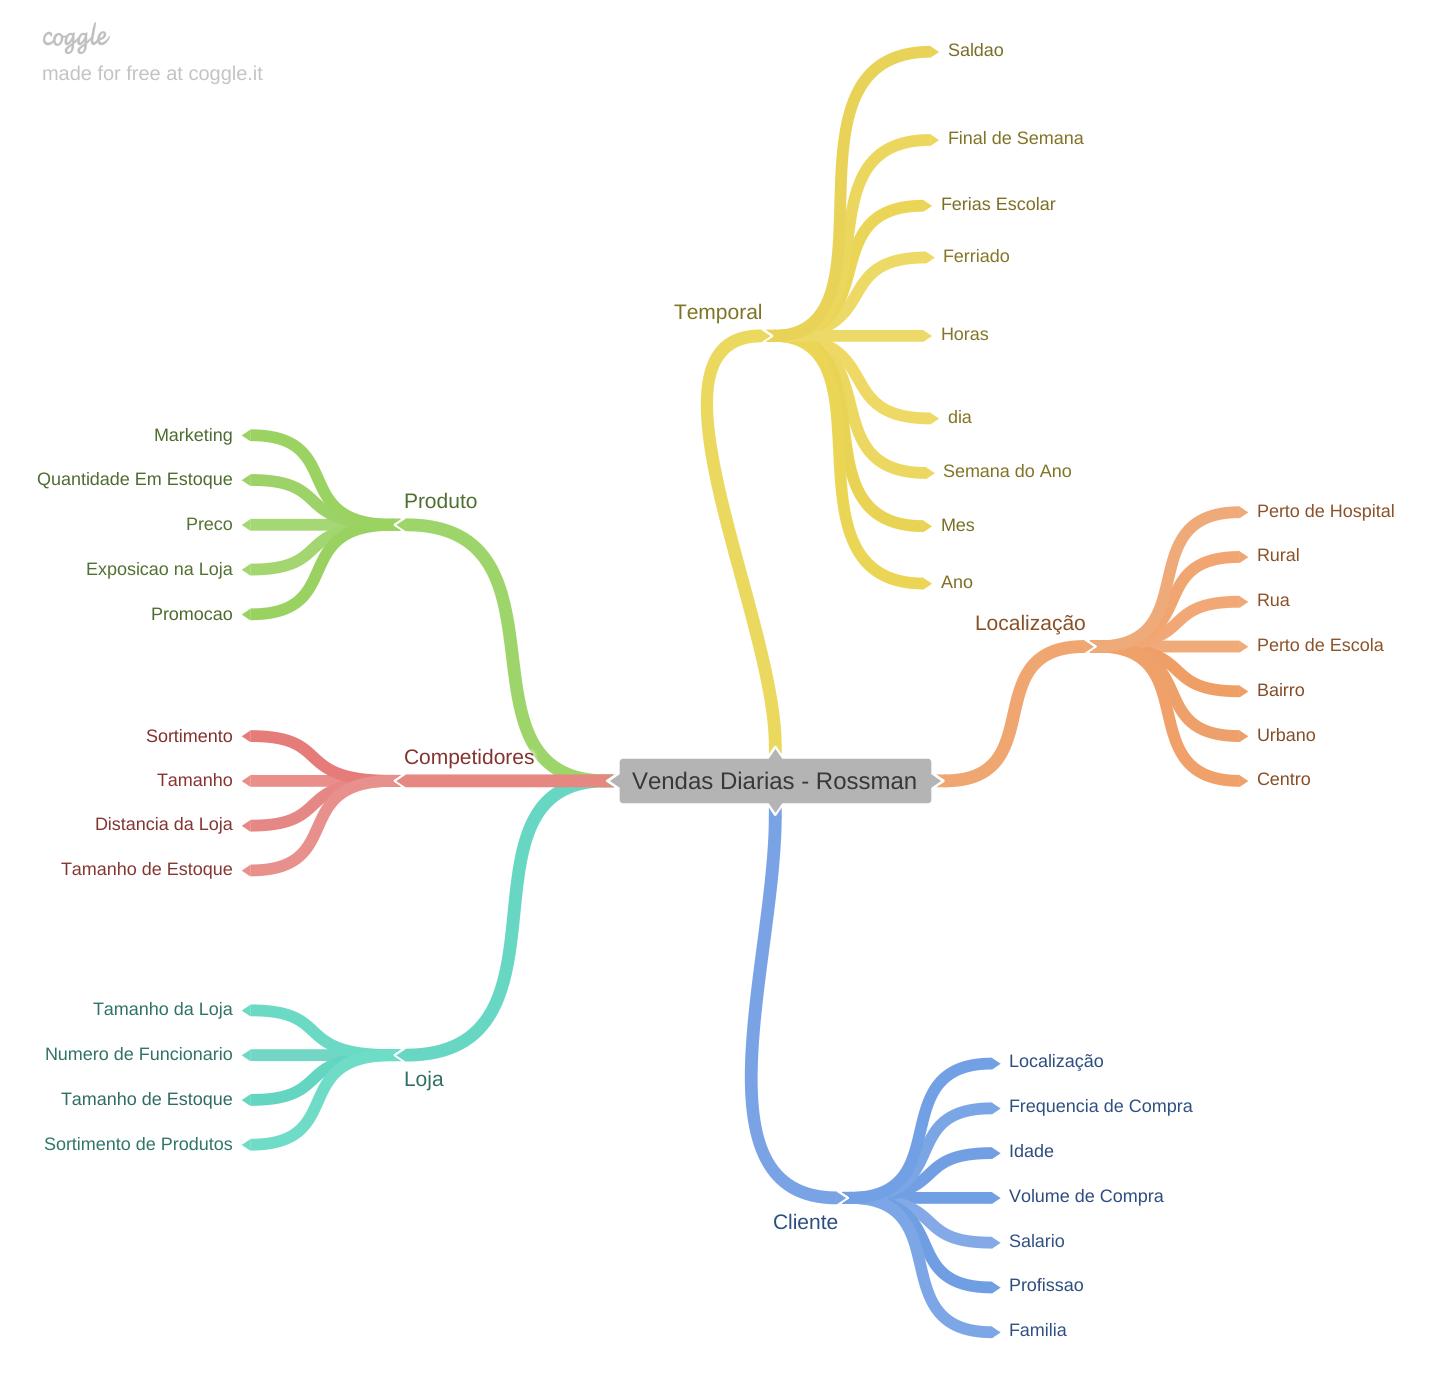

In [22]:
Image('../img/Vendas_Diarias_-_Rossman.png')

##  3.2 Hipoteses

### 3.2.1 Hipoteses Loja

**1.** Lojas do tipo **D** vendem 20% a mais que os demais tipos.

**2.** Lojas com o sortimento de produtos do tipo **c**(extendido) devem vender 10% a mais que os demais tipos.  

**3.** Lojas com numero de funcionarios superior a 20 vendem 5% a mais que outras lojas. 

**4.** Lojas com maior estoque devem vender 10% a mais. 

### 3.2.2 Hipoteses Produto

**1.** Lojas que investem 5% a mais em marketing vendem 10% a mais.

**2.** Lojas com produto exposto na vitrine deveriam vender mais.

**3.** Lojas com produtos com preco 5% menor deveriam vender 10% mais. 

**4.** Lojas com 10% de desconto deveriam vender 15% mais. 

**5.** Lojas com grande quantidade do produtos em estoque deveriam vender 10% mais.

### 3.2.3 Hipoteses Tempo

**1.** Lojas vendem 15% mais no natal do que em outros feriados.

**2.** Lojas deveriam vender 5% a mais ao longo dos anos. 

**3.** Lojas abertas no feriados vendem 20% menos. 

**4.** Lojas vendem 10% a mais no final de semana. 

**5.** Lojas vendem 20% mais no segundo semestre do ano.

**6.** Lojas vendem 15% menos durante ferias escolares.

**7.** Lojas que entram em promocao consecutivas vendem 20% mais. 

**8.** Lojas que ficam mais de 2 meses em promocao vendem 10% menos. 

### 3.2.4 Hipoteses Competidores

**1.** Lojas com competidores a menos de 1000m de distancia vendem 10% 

## 3.3 Lista Final de Hipoteses 

**1.** Lojas do tipo **D** vendem 20% a mais que os demais tipos.

**2.** Lojas com o sortimento de produtos do tipo **c**(extendido) devem vender 10% a mais que os demais tipos.  

**3.** Lojas com competidores a menos de 1000m de distancia vendem 10% 

**4.** Lojas vendem 15% mais no natal do que em outros feriados.

**5.** Lojas abertas no feriados vendem 20% menos. 

**6.** Lojas que entram em promocao consecutivas vendem 20% mais. 

**7.** Lojas que ficam mais de 2 meses em promocao vendem 10% menos. 

**8.** Lojas deveriam vender 5% a mais ao longo dos anos. 

**9.** Lojas abertas no feriados vendem 20% menos. 

**10.** Lojas vendem 10% a mais no final de semana. 

**11.** Lojas vendem 20% mais no segundo semestre do ano.

**12.** Lojas vendem 15% menos durante ferias escolares.

## 3.4 Feature Engineering  

In [23]:
#year
df3['year'] = df3['date'].dt.year

#month
df3['month'] = df3['date'].dt.month

#day
df3['day'] = df3['date'].dt.day

#week of year
df3['week_of_year'] = df3['date'].dt.weekofyear
                
#year week
df3['year_week'] = df3['date'].dt.strftime('%Y-%W')


#promo Since
df3['promo2_since'] = df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str)
df3['promo2_since'] = df3['promo2_since'].apply(lambda x : 0 if x == '0-0' else datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df3['promo2_time_week'] = df3.apply(lambda x: 0 if x['promo2_since'] == 0 else ((x['date']-x['promo2_since'])/7).days, axis=1).astype(int)

#assortiment
df3['assortment'] = df3['assortment'].apply(lambda x : 'basic' if  x=='a'  else 'extra' if x=='b' else 'extended')

#state holiday
df3['state_holiday'] = df3['state_holiday'].apply(lambda x : 'public holiday' if  x=='a' else 'Easter holiday' if x=='b' 
                                                  else 'Christmas' if x=='c' else 'regular day')

/tmp/ipykernel_2573/2204110455.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df3['week_of_year'] = df3['date'].dt.weekofyear


# 4.0 Filtragem de Atributos  

In [25]:
df4 = df3.copy()

## 4.1 Filtragem das Linhas 

In [30]:
df4 = df4[df4['open']!=0] 

## 4.2  Filtragem das Colunas 

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df4 = df4.drop(cols_drop, axis=1)